# **Sentiment Analysis for Airline Reviews**
---


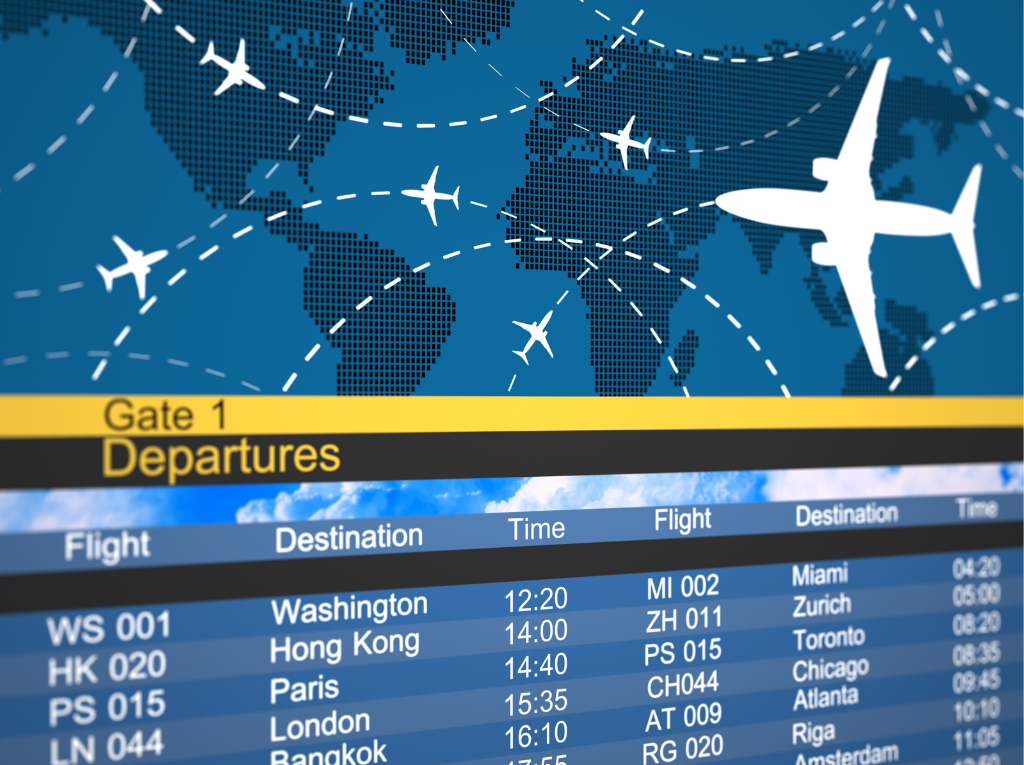

## **Introduction**
---
### **1.1 Project Overview**
- This project aims to perform sentiment analysis on airline reviews to classify them as either positive or negative. The analysis is crucial for understanding customer satisfaction and pinpointing areas that require improvement.
---
### **1.2 Objectives**
The primary objectives of this project are:
- **Data Collection:** Obtain airline reviews from a reliable source.
- **Data Preprocessing:** Clean and prepare the text data for analysis.
- **Exploratory Data Analysis (EDA):** Investigate the data to identify patterns and insights.
- **Model Development:** Build and train a sentiment analysis model.
- **Model Evaluation:** Assess the model's performance using relevant metrics.
- **Visualization:** Present insights with interactive and appealing visualizations.
---
### **1.3 Importance of Sentiment Analysis**
- Sentiment analysis provides actionable insights into customer opinions and feelings, enabling businesses to enhance their service quality, customer satisfaction, and overall competitiveness.
---
### **1.4 Scope**
This notebook covers the following steps:
- Data Collection
- Data Cleaning and Preprocessing
- Exploratory Data Analysis (EDA)
- Model Development and Handling Class Imbalance
- Model Evaluation
- Visualization Dashboard
- Conclusion and Future Work


### **1.5 Import necessary libraries**

In [ ]:
# Importing essential libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk

# Importing libraries for text preprocessing and NLP tasks
import re
import string
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Importing libraries for machine learning model development
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Importing libraries for handling class imbalance
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Importing libraries for advanced NLP tasks and visualizations
from transformers import pipeline
from wordcloud import WordCloud

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

## **2. Data Collection**
---
### **2.1 Data Source**
The dataset contains airline reviews, including the following key columns:
- `Review_Date`: The date on which the review was posted.
- `Review_Text`: The content of the review.
---
### **2.2 Initial Data Exploration**
Let's load the dataset and inspect the first few rows to understand its structure.


In [ ]:
data = pd.read_csv('/content/Airline_Reviews.csv') # Load the dataset from a CSV file
data.head()

In [ ]:
df=data.copy() # Create a copy of the dataset for further analysis
df.head()

In [ ]:
df.info() # Get information about the dataset, including data types and missing values

In [ ]:
df.shape

In [ ]:
df.nunique() # Check the number of unique values in each column

In [ ]:
df.isnull().sum() # Count the number of missing values in each column

In [ ]:
df['Review_Date'] = pd.to_datetime(df['Review_Date'], format='mixed') # The format='mixed' argument tells pandas to try to infer the format of each date individually

In [ ]:
df.columns # Get the list of column names in the dataset

In [ ]:
# Drop unnecessary columns
df = df.drop(columns=['Airline_Name', 'Overall_Rating', 'Review_Title',
       'Verified', 'Aircraft', 'Type of Traveller', 'Seat Type',
       'Route', 'Date Flown', 'Seat Comfort', 'Cabin Staff Service',
       'Food & Beverages', 'Ground Service', 'Inflight Entertainment',
       'Wifi & Connectivity', 'Value for Money', 'Recommended'])

In [ ]:
# Convert Review_Date to datetime
df['Review_Date'] = pd.to_datetime(df['Review_Date'],format='mixed', errors='coerce')
# Drop rows where Review_Date could not be converted
df = df.dropna(subset=['Review_Date'])
# Set Review_Date as the index
df.set_index('Review_Date', inplace=True)
print(df.head())

In [ ]:
df.head()

In [ ]:
df.tail()

## **3. Data Cleaning and Preprocessing**
---
### **3.1 Initial Cleaning**
- We begin by removing any rows with missing or duplicate review texts to ensure data quality.
---
### **3.2 Text Preprocessing**
To prepare the review texts for sentiment analysis, we apply the following preprocessing steps:
- **Lowercasing:** Convert all text to lowercase to standardize the data.
- **Short Word Removal:** Remove words with less than three characters, which often do not contribute to sentiment.
- **Punctuation and Number Removal:** Strip out punctuation and numbers, which are not useful for sentiment analysis.
- **Tokenization and Stopword Removal:** Break the text into tokens and remove common stopwords that do not carry sentiment.

These preprocessing steps are crucial for ensuring that the text data is in the best possible shape for analysis.


In [ ]:
def clean_text(text):
    """
    Function to clean text data by removing HTML tags, special characters,
    and converting text to lowercase.

    Parameters:
    text (str): The input text to be cleaned.

    Returns:
    str: The cleaned text.
    """
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers, keeping only alphabetic characters and whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

# Apply the cleaning function to the 'Review_Text' column
df['cleaned_text'] = df['Review_Text'].apply(clean_text)
# Display the original and cleaned text for comparison
print(df[['Review_Text', 'cleaned_text']].head())

In [ ]:
# clean date
def clean_date(date):
  """
  Function to extract year from a datetime object.

  Parameters:
  date (datetime): The input date.

  Returns:
  int: The year extracted from the date.
  """
  return date.year

# Apply the cleaning function to the index (Review_Date)
df['Date'] = df.index.to_series().apply(clean_date)
# Display the DataFrame with the extracted year
print(df.head())

In [ ]:
def tokenize_and_remove_stopwords(text):
    """
    This function takes a text string as input, tokenizes it into individual words,
    and removes common stopwords (e.g., 'the', 'and', 'is') from the tokenized words.

    Parameters:
    text (str): The text string to be processed.

    Returns:
    list: A list of tokens with stopwords removed.
    """
    # Tokenize the input text into individual words
    tokens = word_tokenize(text)

    # Define the set of English stopwords
    stop_words = set(stopwords.words('english'))

    # Filter out stopwords from the list of tokens
    tokens = [word for word in tokens if word.lower() not in stop_words]

    return tokens

# Apply the tokenization and stopword removal to the 'cleaned_text' column
df['tokens'] = df['cleaned_text'].apply(tokenize_and_remove_stopwords)

# Display the first few rows of the 'cleaned_text' and 'tokens' columns
print(df[['cleaned_text', 'tokens']].head())

In [ ]:
def lemmatize_tokens(tokens):
    """
    This function takes a list of tokens and applies lemmatization to each token.
    Lemmatization reduces words to their base or root form (e.g., 'running' to 'run').

    Parameters:
    tokens (list): A list of tokens (words) to be lemmatized.

    Returns:
    list: A list of lemmatized tokens.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize each token in the list
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return lemmatized_tokens

# Apply lemmatization to the 'tokens' column
df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_tokens)

# Optional: Join the lemmatized tokens back into a single text string
df['final_text'] = df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# Display the first few rows of the 'tokens', 'lemmatized_tokens', and 'final_text' columns
print(df[['tokens', 'lemmatized_tokens', 'final_text']].head())

### **3.3 Word Cloud Generation from Cleaned and Lemmatized Reviews**

In [ ]:
# This string will contain all the words from the 'final_text' column of the DataFrame
all_words = ' '.join(df['final_text'])

# Create a Word Cloud object with specified width, height, and background color
# Generate the word cloud using the combined text data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))  # Set the size of the figure
plt.imshow(wordcloud, interpolation='bilinear')  # Display the Word Cloud image
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Cleaned and Lemmatized Reviews')  # Set the title of the plot
plt.show()  # Display the plot

### **4. TF-IDF Vectorization and Word Cloud Visualization of Unigrams and Bigrams**

- In this analysis, we perform TF-IDF (Term Frequency-Inverse Document Frequency) vectorization on a dataset of text reviews.
- This technique helps identify the importance of words and phrases within the text by considering both their frequency in individual documents and their rarity across all documents. We include both unigrams (single words) and bigrams (two-word combinations) to capture a broader range of keywords. Following the vectorization, we visualize the most significant keywords using a word cloud.


In [ ]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

# Fit and transform the text data
tfidf_matrix = tfidf.fit_transform(df['final_text'])

# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

# Sum the TF-IDF scores for each word across all documents
sum_tfidf = tfidf_matrix.sum(axis=0)

# Create a DataFrame to store words and their total TF-IDF scores
word_tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf': sum_tfidf.A1})

# Sort the DataFrame by TF-IDF scores in descending order
word_tfidf_df = word_tfidf_df.sort_values(by='tfidf', ascending=False)

# Display the top 10 most frequent words
print("Top 10 Most Frequent Words Across All Documents:")
print(word_tfidf_df.head(10))

# Create a word cloud for the most frequent keywords
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='viridis',  # Color map for the word cloud
                      contour_color='black',  # Contour color around words
                      contour_width=1,  # Contour width
                      max_font_size=150,
                      min_font_size=10).generate_from_frequencies(word_tfidf_df.set_index('word')['tfidf'])

In [ ]:
# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words Across All Documents', fontsize=16)
plt.show()

In [ ]:
# Plot the top 20 most frequent words
top_n = 20
plt.figure(figsize=(12, 8))
plt.barh(word_tfidf_df.head(top_n)['word'], word_tfidf_df.head(top_n)['tfidf'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.title('Top 20 Most Frequent Words Across All Documents')
plt.gca().invert_yaxis()  # To display the highest scores on top
plt.show()

In [ ]:
# List of terms to visualize
terms = ['service', 'flight', 'staff']

# Ensure feature_names is a list
feature_names = list(feature_names)

plt.figure(figsize=(14, 8))

for term in terms:
    if term in feature_names:
        term_idx = feature_names.index(term)
        term_tfidf = tfidf_matrix[:, term_idx].toarray().flatten()
        df['term_tfidf'] = term_tfidf

        # Plotting the term's TF-IDF score over time
        plt.plot(df.index, df['term_tfidf'], label=term, linewidth=2)

# Enhancing the plot
plt.xlabel('Date', fontsize=14)
plt.ylabel('TF-IDF Score', fontsize=14)
plt.title('TF-IDF Scores of Terms Over Time', fontsize=16)
plt.legend(title='Terms', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### **5. Sentiment Analysis using DistilBERT Model**

In this section, we leverage the `distilbert-base-uncased-finetuned-sst-2-english` model to perform sentiment analysis on the text data in our dataset. DistilBERT is a streamlined version of BERT optimized for performance in sentiment analysis tasks.
   

In [ ]:
# Load the sentiment analysis model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

# Apply sentiment analysis
df['sentiment'] = df['final_text'].apply(lambda text: sentiment_pipeline(text[:512])[0]['label'])

# Observe the results
print(df[['final_text', 'sentiment']].head())

### **5.1 Analyzing Sentiment Distribution**


In [ ]:
# Count the occurrences of POSITIVE and NEGATIVE sentiments
sentiment_counts = df['sentiment'].value_counts().reset_index()

# Rename the columns for clarity
sentiment_counts.columns = ['Sentiment', 'Count']

# Display the result as a DataFrame
print(sentiment_counts)

In [ ]:
# Visualizing sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
# Creating separate Word Clouds for positive and negative reviews
positive_text = ' '.join(df[df['sentiment'] == 'POSITIVE']['final_text'])
negative_text = ' '.join(df[df['sentiment'] == 'NEGATIVE']['final_text'])

plt.figure(figsize=(12, 6))

# Word Cloud for positive reviews
plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')

# Word Cloud for negative reviews
plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

### **5.2 Identifying Key Terms in Positive and Negative Reviews Using TF-IDF Analysis**
- This code snippet aims to identify and highlight the most important terms in positive and negative reviews by employing TF-IDF (Term Frequency-Inverse Document Frequency) analysis. TF-IDF is a technique used in text mining to measure the relevance of words within a document relative to a collection of document

In [ ]:
# Define a function to get top words based on TF-IDF scores
def get_top_n_words(corpus, n=None):
    """
    Function to extract top n words with the highest TF-IDF scores from a given corpus.

    Parameters:
    corpus (list of str): The corpus of text data.
    n (int): The number of top words to extract.

    Returns:
    pd.DataFrame: A DataFrame containing words and their corresponding TF-IDF scores.
    """
    vec = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vec.fit_transform(corpus)
    sum_tfidf = tfidf_matrix.sum(axis=0)
    words_scores = [(word, sum_tfidf[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_scores = sorted(words_scores, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_scores, columns=['Word', 'TF-IDF']).head(n)

# Get top 10 words from positive reviews
positive_words_df = get_top_n_words(df[df['sentiment'] == 'POSITIVE']['final_text'], n=10)
print("Top Positive Words:")
print(positive_words_df)

# Get top 10 words from negative reviews
negative_words_df = get_top_n_words(df[df['sentiment'] == 'NEGATIVE']['final_text'], n=10)
print("\nTop Negative Words:")
print(negative_words_df)


In [ ]:
# Combine all positive and negative reviews
positive_words = ' '.join(df[df['sentiment'] == 'POSITIVE']['final_text']).split()
negative_words = ' '.join(df[df['sentiment'] == 'NEGATIVE']['final_text']).split()

# Count the frequency of words
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Get the top 10 most common positive and negative words
top_positive_words = dict(positive_word_counts.most_common(10))
top_negative_words = dict(negative_word_counts.most_common(10))

# Create a DataFrame for easy plotting
top_words_df = pd.DataFrame({
    'word': list(top_positive_words.keys()) + list(top_negative_words.keys()),
    'frequency': list(top_positive_words.values()) + list(top_negative_words.values()),
    'sentiment': ['Positive'] * len(top_positive_words) + ['Negative'] * len(top_negative_words)
})

# Plot the data
plt.figure(figsize=(14, 7))
sns.barplot(x='frequency', y='word', hue='sentiment', data=top_words_df, palette='coolwarm')
plt.title('Top Positive and Negative Words', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.legend(title='Sentiment', loc='upper right')
plt.show()

### **6. Sentiment Classification using Logistic Regression: Model Training, Evaluation, and Confusion Matrix Visualization**


In [ ]:
# Assuming the dataframe 'df' has columns 'final_text' and 'sentiment_label'
# Duyguları sayısal değerlere dönüştürün
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])
# Split the data into training and testing sets
X = df['final_text']
y = df['sentiment_label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the text data into numerical data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train_vec, y_train)

# Predict the sentiment labels for the test set
y_pred_labels = model.predict(X_test_vec)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

In [ ]:
# Visualize Precision, Recall, and F1-Score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance by Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

In [ ]:
# # Convert confusion matrix to a DataFrame
# conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

# # Display the confusion matrix DataFrame
# print("Confusion Matrix:")
# print(conf_matrix_df)
# # Display the classification report DataFrame
# print("Classification Report:")
# print(report_df)


In [ ]:
report_df = pd.DataFrame(report).transpose()
report_df

### **7. Handling Class Imbalance in Sentiment Classification: SMOTE Resampling and Data Preparation**

In [ ]:
# Encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])

# Features and labels
X = df['final_text']
y = df['sentiment_label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to numerical data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

# Display class distribution after SMOTE
print("Original class distribution:\n", pd.Series(y_train).value_counts())
print("Resampled class distribution:\n", pd.Series(y_train_resampled).value_counts())

# Now proceed to model training and evaluation

In [ ]:
# Convert the test data using the TF-IDF vectorizer
X_test_vec = vectorizer.transform(X_test)

# Train the Logistic Regression model using resampled data
model = LogisticRegression(max_iter=200)
model.fit(X_train_resampled, y_train_resampled)

# Predict sentiment labels for the test set
y_pred_labels = model.predict(X_test_vec)

# Generate and visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate and visualize the classification report
report = classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance by Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

In [ ]:
#Classification Report as a DataFrame
print("Classification Report:")
print(report_df)

### **7.1 Handling Class Imbalance and Model Evaluation**

In [ ]:
# Creating and transforming with TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = df['final_text']
y = df['sentiment_label']
X_vec = vectorizer.fit_transform(X)

# Splitting data into training and test sets
X_train_vec, X_test_vec, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Addressing class imbalance through oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

# Training the model
model = LogisticRegression(max_iter=200)
model.fit(X_train_resampled, y_train_resampled)

# Making predictions on the test data
y_pred_labels = model.predict(X_test_vec)

# Generating confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_labels)
report = classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Visualizing the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# prompt: model save

import pickle

# Save the model to a file
filename = 'log_sentiment_model.sav'
pickle.dump(model, open(filename, 'wb'))


In [ ]:
# prompt: model loading

# Load the saved model
log_model = pickle.load(open('log_sentiment_model.sav', 'rb'))


In [ ]:
# prompt: gtive me code to test model

# Sample text for testing
new_text = [input("Enter the comment: ")]

# Preprocess the new text (apply the same preprocessing steps as before)
# ... (add your preprocessing steps here, e.g., tokenization, lemmatization)

# Transform the new text using the same TF-IDF vectorizer
new_text_vec = vectorizer.transform(new_text)

# Make predictions using the loaded model
predictions = log_model.predict(new_text_vec)

# Print the predictions
print(predictions)


In [ ]:
# Visualizing Precision, Recall, and F1-Score
plt.figure(figsize=(14, 6))

# Bar width and positioning
bar_width = 0.10
index = range(len(report_df) - 3)  # Excludes the last 3 rows (accuracy, macro avg, weighted avg)

# Precision bars
plt.bar([i - bar_width for i in index], report_df['precision'].iloc[:-3], bar_width, label='Precision', color='#1f77b4', edgecolor='black')
# Recall bars
plt.bar(index, report_df['recall'].iloc[:-3], bar_width, label='Recall', color='#ff7f0e', edgecolor='black')
# F1-Score bars
plt.bar([i + bar_width for i in index], report_df['f1-score'].iloc[:-3], bar_width, label='F1-Score', color='#2ca02c', edgecolor='black')

plt.xlabel('Sentiment Class', fontsize=12)
plt.ylabel('Score', fontsize=10)
plt.title('Model Performance by Sentiment Class', fontsize=16)
plt.xticks(index, report_df.index[:-3], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Displaying values on top of each bar
for i in index:
    plt.text(i - bar_width, report_df['precision'].iloc[i], f'{report_df["precision"].iloc[i]:.2f}', ha='center', va='bottom', fontsize=12)
    plt.text(i, report_df['recall'].iloc[i], f'{report_df["recall"].iloc[i]:.2f}', ha='center', va='bottom', fontsize=12)
    plt.text(i + bar_width, report_df['f1-score'].iloc[i], f'{report_df["f1-score"].iloc[i]:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
#Classification Report as a DataFrame
print("Classification Report:")
print(report_df)

### **8. Sentiment Trends Over Time**

In [ ]:
# Count the number of positive and negative sentiments
sentiment_counts = df.groupby(['Date', 'sentiment']).size().unstack().fillna(0)

# Plot the sentiment distribution over time
sentiment_counts.plot(kind='bar', stacked=True, figsize=(14, 8), color=['red', 'green'])

plt.title('Sentiment Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

### Conclusion

This comprehensive analysis of airline reviews has offered valuable insights into customer sentiment and trends through the application of natural language processing techniques. The following key findings summarize the results:

- **Most Frequent Words:** We identified the most common words and phrases used in reviews, highlighting both positive and negative aspects of the airline experience.
- **Sentiment Distribution:** The analysis determined the overall sentiment distribution, revealing the proportions of positive and negative reviews.
- **Key Terms in Sentiments:** Significant terms associated with positive and negative sentiments were uncovered, providing a deeper understanding of the drivers behind customer satisfaction and dissatisfaction.
- **Sentiment Classification:** A logistic regression model was developed to classify sentiments, showing promising results in predicting customer sentiment based on textual data.
- **Class Imbalance Handling:** Class imbalance issues were addressed using SMOTE resampling, enhancing the model’s accuracy in classifying both positive and negative sentiments.
- **Sentiment Trends Over Time:** Sentiment trends were visualized over time, revealing shifts in customer satisfaction and identifying areas for improvement.

These insights enable airlines to:

- **Proactively Address Concerns:** Identify and mitigate recurring negative feedback to boost customer satisfaction.
- **Capitalize on Strengths:** Utilize positive feedback to reinforce effective strategies and strengthen customer loyalty.
- **Monitor Sentiment Trends:** Track changes in sentiment over time to detect emerging issues and adapt strategies as needed.

By leveraging these data-driven insights, airlines can make informed decisions to enhance the customer experience and achieve greater success in the competitive aviation industry.